In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from category_encoders import CatBoostEncoder
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
import math
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from hyperopt import hp, fmin, tpe, Trials
import shap
from catboost.utils import get_roc_curve
from catboost import Pool
from lightgbm import LGBMRegressor
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt

import wandb
from transformers import AutoModel

C:\Users\master\anaconda3\envs\EDA\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
wandb.login()
wandb.init(project="stacking-ensemble-regression")

wandb: Currently logged in as: suksa (ssuksa). Use `wandb login --relogin` to force relogin


Explained Variance Ratio by Each Principal Component:
PC1: 0.3703
PC2: 0.2342
PC3: 0.1586
PC4: 0.1219
PC5: 0.0913
PC6: 0.0098
PC7: 0.0051
PC8: 0.0039
PC9: 0.0026
PC10: 0.0017
PC11: 0.0005

Cumulative Explained Variance Ratio:
PC1: 0.3703
PC2: 0.6045
PC3: 0.7631
PC4: 0.8850
PC5: 0.9763
PC6: 0.9861
PC7: 0.9912
PC8: 0.9952
PC9: 0.9978
PC10: 0.9995
PC11: 1.0000


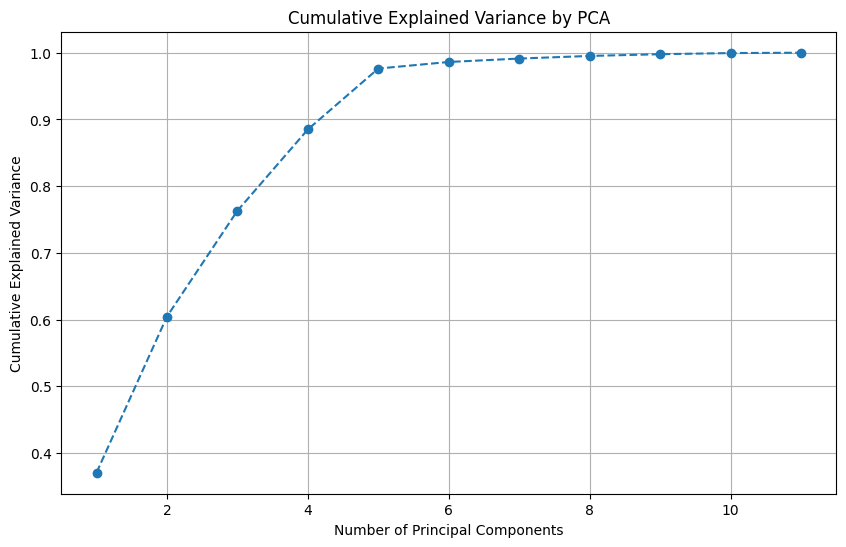

In [3]:
org_data_train = pd.read_csv('autoam-car-price-prediction/train.csv')
org_data_test = pd.read_csv('autoam-car-price-prediction/test.csv')
save_data_train = deepcopy(org_data_train)
save_data_test = deepcopy(org_data_test)

def km_mile_convert(value):
    if 'km' in value:
        return float(value.replace(' km', ''))  # km를 miles로 변환
    elif 'miles' in value:
        return round(float(value.replace(' miles', '')) * 1.60934, 2) # 그대로 반환
    
org_data_train['running'] = org_data_train['running'].apply(km_mile_convert)
org_data_test['running'] = org_data_test['running'].apply(km_mile_convert)



# wheel 데이터는 전부 left여서 컬럼자체를 드랍
org_data_train.drop('wheel', axis=1, inplace=True)

# 상관관계 분석결과 motor_volume은 관계성이 0에 가까우므로 우선 드랍
org_data_train.drop('motor_volume', axis=1, inplace=True)


# test에 적용
org_data_test.drop('wheel', axis=1, inplace=True)
org_data_test.drop('motor_volume', axis=1, inplace=True)



# moter_type 원핫 인코딩, 범주가 5개이며, 데이터가 불균형하여 해당 인코딩 선택
one_hot_motor_type = deepcopy(org_data_train['motor_type'])
one_hot_motor_type = pd.get_dummies(one_hot_motor_type, dtype = int)
org_data_train.drop('motor_type', axis=1, inplace=True)
org_data_train = pd.concat([org_data_train, one_hot_motor_type], axis=1)

# test에 적용
one_hot_motor_type = deepcopy(org_data_test['motor_type'])
one_hot_motor_type = pd.get_dummies(one_hot_motor_type, dtype = int)
org_data_test.drop('motor_type', axis=1, inplace=True)
org_data_test = pd.concat([org_data_test, one_hot_motor_type], axis=1)


# mean 값의 차이가 10%이하인 color 데이터를 other로 변경
low_color = ['red', 'cherry', 'brown', 'pink']

org_data_train['color'] = org_data_train['color'].replace({'red' : 'other', 'cherry' : 'other', 
                                                          'brown' : 'other', 'pink' : 'other'})


# test에도 적용
org_data_test['color'] = org_data_test['color'].replace({'red' : 'other', 'cherry' : 'other', 
                                                          'brown' : 'other', 'pink' : 'other'})


# 전체 원핫 인코딩, 범주가 5개이며, 데이터가 불균형하여 해당 인코딩 선택
one_hot_motor_type = deepcopy(org_data_train[['type', 'model', 'color', 'status']])
one_hot_motor_type = pd.get_dummies(one_hot_motor_type, dtype = int)

one_hot_org_data = deepcopy(org_data_train).drop(['type', 'model', 'color', 'status'], axis=1)
one_hot_org_data = pd.concat([one_hot_org_data, one_hot_motor_type], axis=1)
#org_data_train.drop('motor_type', axis=1, inplace=True)
#org_data_train = pd.concat([org_data_train, one_hot_motor_type], axis=1)

# 전체 원핫 인코딩, 범주가 5개이며, 데이터가 불균형하여 해당 인코딩 선택
one_hot_motor_type = deepcopy(org_data_test[['type', 'model', 'color', 'status']])
one_hot_motor_type = pd.get_dummies(one_hot_motor_type, dtype = int)

one_hot_test_data = deepcopy(org_data_test).drop(['type', 'model', 'color', 'status'], axis=1)
one_hot_test_data = pd.concat([one_hot_test_data, one_hot_motor_type], axis=1)
#org_data_train.drop('motor_type', axis=1, inplace=True)
#org_data_train = pd.concat([org_data_train, one_hot_motor_type], axis=1)


#test하고 train셋에서 motor type확인해보면 test에서 diesel과 hybrid가 없음, 컬럼제거함
one_hot_org_data = one_hot_org_data.drop(columns=['diesel', 'hybrid'])
del_000_list = one_hot_org_data[(one_hot_org_data['gas'] == 0) & (one_hot_org_data['petrol'] == 0) & (one_hot_org_data['petrol and gas'] == 0)].index
one_hot_org_data = one_hot_org_data.drop(del_000_list)


one_hot_org_data = one_hot_org_data.drop_duplicates()
one_hot_org_data = one_hot_org_data.reset_index(drop=True)


one_hot_org_data = one_hot_org_data[['year', 'running', 'price', 'gas', 'petrol', 'petrol and gas',
       'type_Coupe', 'type_Universal', 'type_hatchback',
       'type_minivan / minibus', 'type_pickup', 'type_sedan', 'type_suv',
       'model_hyundai', 'model_kia', 'model_mercedes-benz', 'model_nissan',
       'model_toyota', 'color_beige', 'color_black',
       'color_blue', 'color_clove', 'color_gray', 'color_green',
       'color_orange', 'color_other', 'color_silver', 'color_skyblue',
       'color_white', 'status_crashed', 'status_excellent',
       'status_good', 'status_new', 'status_normal']]

# PCA
c = ['color_beige', 'color_black',
       'color_blue', 'color_clove', 'color_gray', 'color_green',
       'color_orange', 'color_other', 'color_silver', 'color_skyblue',
       'color_white']
pca = PCA(n_components = len(c))  # 모든 주성분을 추출
pca.fit(one_hot_org_data[['color_beige', 'color_black', 'color_blue',
       'color_clove', 'color_gray', 'color_green',
       'color_orange', 'color_other', 'color_silver',
       'color_skyblue', 'color_white']])
explained_variance_ratio = pca.explained_variance_ratio_


# 결과 출력
print("Explained Variance Ratio by Each Principal Component:")
for i, variance in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {variance:.4f}")

# 누적 분산 설명량 계산
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# 누적 분산 설명량 출력
print("\nCumulative Explained Variance Ratio:")
for i, cumulative_variance in enumerate(cumulative_explained_variance):
    print(f"PC{i+1}: {cumulative_variance:.4f}")
    
# 누적 분산 설명량 그래프
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(c) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

one_hot_org_data[['color_beige', 'color_black', 'color_blue',
       'color_clove', 'color_gray', 'color_green',
       'color_orange', 'color_other', 'color_silver',
       'color_skyblue', 'color_white']]



pca = PCA(n_components = 5)

# 컬러 pca train data
pca_transformed_train = pca.fit_transform(one_hot_org_data[['color_beige', 'color_black', 'color_blue',
       'color_clove', 'color_gray', 'color_green',
       'color_orange', 'color_other', 'color_silver',
       'color_skyblue', 'color_white']])

pca_columns = [f'color{i+1}' for i in range(pca_transformed_train.shape[1])]
pca_df_train = pd.DataFrame(pca_transformed_train, columns=pca_columns)


color_train = pd.concat([one_hot_org_data.drop(c, axis=1), pca_df_train], axis=1)


# 컬러 pca test data
pca_transformed = pca.transform(one_hot_test_data[['color_beige', 'color_black', 'color_blue',
       'color_clove', 'color_gray', 'color_green',
       'color_orange', 'color_other', 'color_silver',
       'color_skyblue', 'color_white']])
pca_columns = [f'color{i+1}' for i in range(pca_transformed.shape[1])]
pca_df = pd.DataFrame(pca_transformed, columns=pca_columns)

color_test = pd.concat([one_hot_test_data.drop(['color_beige', 'color_black', 'color_blue',
       'color_clove', 'color_gray', 'color_green',
       'color_orange', 'color_other', 'color_silver',
       'color_skyblue', 'color_white'], axis=1), pca_df], axis=1)



In [5]:
# 랜덤포레스트, lightgbm, xgboost, catboost 스택킹 앙상블

X = color_train.drop('price', axis=1)
y = color_train['price']

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Sweep 설정
sweep_configuration = {
    'method': 'bayes',
    'metric': {'name': 'mae', 'goal': 'minimize'},
    'parameters': {
        'rf_n_estimators': {'values': [50, 100, 200]},
        'xgb_n_estimators': {'values': [50, 100, 200]},
        'lgbm_n_estimators': {'values': [50, 100, 200]},
        'catboost_iterations': {'values': [50, 100, 200]},
        'catboost_final_iterations': {'values': [50, 100, 200]}
    }
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project="stacking-ensemble-regression")


Create sweep with ID: 7zq4a4oj
Sweep URL: https://wandb.ai/ssuksa/stacking-ensemble-regression/sweeps/7zq4a4oj


In [ ]:
def train():
    # Weights & Biases 실행 초기화
    wandb.init()

    # 랜덤포레스트, lightgbm, xgboost, catboost 스택킹 앙상블

    X = color_train.drop('price', axis=1)
    y = color_train['price']

    # 학습/테스트 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 하이퍼파라미터 설정
    rf_n_estimators = wandb.config.rf_n_estimators
    xgb_n_estimators = wandb.config.xgb_n_estimators
    lgbm_n_estimators = wandb.config.lgbm_n_estimators
    catboost_iterations = wandb.config.catboost_iterations
    catboost_final_iterations = wandb.config.catboost_final_iterations

    # 기본 모델 설정
    estimators = [
        ('rf', RandomForestRegressor(n_estimators=rf_n_estimators, random_state=42)),
        ('xgb', XGBRegressor(n_estimators=xgb_n_estimators, random_state=42)),
        ('lgbm', LGBMRegressor(n_estimators=lgbm_n_estimators, random_state=42)),
        ('catboost', CatBoostRegressor(iterations=catboost_iterations, random_seed=42, silent=True))
    ]

    # 스태킹 모델 설정 (최종 모델로 CatBoost 사용)
    stacking_model = StackingRegressor(
        estimators=estimators,
        final_estimator=CatBoostRegressor(iterations=catboost_final_iterations, random_seed=42, silent=True)
    )

    # 모델 학습
    stacking_model.fit(X_train, y_train)

    # 예측
    y_pred = stacking_model.predict(X_test)

    # 평가 (MAE)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Absolute Error: {mae}')

    # 결과를 Weights & Biases에 로깅
    wandb.log({"mae": mae})

# Sweep agent 실행
wandb.agent(sweep_id, function=train)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: onzklk15 with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 100
wandb: 	rf_n_estimators: 200
wandb: 	xgb_n_estimators: 100


Mean Absolute Error: 1938.3649745849016


mae,▁
mae,1938.36497


wandb: Agent Starting Run: spokr9g4 with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 50
wandb: 	lgbm_n_estimators: 200
wandb: 	rf_n_estimators: 100
wandb: 	xgb_n_estimators: 50


Mean Absolute Error: 2232.7815253925737


mae,▁
mae,2232.78153


wandb: Agent Starting Run: j7k7jjv0 with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 50
wandb: 	lgbm_n_estimators: 100
wandb: 	rf_n_estimators: 100
wandb: 	xgb_n_estimators: 100


Mean Absolute Error: 2181.5939872419453


mae,▁
mae,2181.59399


wandb: Agent Starting Run: zwv7lu4k with config:
wandb: 	catboost_final_iterations: 100
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 100
wandb: 	rf_n_estimators: 200
wandb: 	xgb_n_estimators: 200


Mean Absolute Error: 1998.2102037144152


mae,▁
mae,1998.2102


wandb: Agent Starting Run: vmc4bkjs with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 100
wandb: 	rf_n_estimators: 200
wandb: 	xgb_n_estimators: 200


Mean Absolute Error: 2014.2441617282225


mae,▁
mae,2014.24416


wandb: Agent Starting Run: 257zwfak with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 50
wandb: 	rf_n_estimators: 200
wandb: 	xgb_n_estimators: 100


Mean Absolute Error: 2064.1896369402643


mae,▁
mae,2064.18964


wandb: Agent Starting Run: r9jdkiab with config:
wandb: 	catboost_final_iterations: 100
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 200
wandb: 	rf_n_estimators: 200
wandb: 	xgb_n_estimators: 100


Mean Absolute Error: 1985.7441848308576


mae,▁
mae,1985.74418


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 123e1fez with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 200
wandb: 	rf_n_estimators: 200
wandb: 	xgb_n_estimators: 100


Mean Absolute Error: 1922.03003132316


mae,▁
mae,1922.03003


wandb: Agent Starting Run: hvyhe4a5 with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 200
wandb: 	rf_n_estimators: 200
wandb: 	xgb_n_estimators: 200


Mean Absolute Error: 1974.7083523677816


mae,▁
mae,1974.70835


wandb: Agent Starting Run: jnndfgi6 with config:
wandb: 	catboost_final_iterations: 100
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 200
wandb: 	rf_n_estimators: 200
wandb: 	xgb_n_estimators: 50


Mean Absolute Error: 1994.0190212560808


mae,▁
mae,1994.01902


wandb: Agent Starting Run: 7g4ogk3m with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 200
wandb: 	rf_n_estimators: 200
wandb: 	xgb_n_estimators: 50


Mean Absolute Error: 2051.682535436938


mae,▁
mae,2051.68254


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y3iqi1ae with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 200
wandb: 	rf_n_estimators: 200
wandb: 	xgb_n_estimators: 200


Mean Absolute Error: 1974.7083523677816


mae,▁
mae,1974.70835


wandb: Agent Starting Run: hbsww7h4 with config:
wandb: 	catboost_final_iterations: 100
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 200
wandb: 	rf_n_estimators: 200
wandb: 	xgb_n_estimators: 200


Mean Absolute Error: 1989.3155913162573


mae,▁
mae,1989.31559


wandb: Agent Starting Run: nfpi5tsi with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 200
wandb: 	rf_n_estimators: 200
wandb: 	xgb_n_estimators: 200


Mean Absolute Error: 1974.7083523677816


mae,▁
mae,1974.70835


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c5h1b2ru with config:
wandb: 	catboost_final_iterations: 200
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 50
wandb: 	rf_n_estimators: 50
wandb: 	xgb_n_estimators: 50


Mean Absolute Error: 2067.56538543047


mae,▁
mae,2067.56539


wandb: Agent Starting Run: etu1gjgb with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 200
wandb: 	rf_n_estimators: 50
wandb: 	xgb_n_estimators: 200


Mean Absolute Error: 2084.2714639823193


mae,▁
mae,2084.27146


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y3p45rp4 with config:
wandb: 	catboost_final_iterations: 200
wandb: 	catboost_iterations: 50
wandb: 	lgbm_n_estimators: 50
wandb: 	rf_n_estimators: 50
wandb: 	xgb_n_estimators: 50


Mean Absolute Error: 2165.310861367937


mae,▁
mae,2165.31086


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i53b5pq5 with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 200
wandb: 	rf_n_estimators: 200
wandb: 	xgb_n_estimators: 200


Mean Absolute Error: 1974.7083523677816


mae,▁
mae,1974.70835


wandb: Agent Starting Run: z7xzd19a with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 200
wandb: 	rf_n_estimators: 200
wandb: 	xgb_n_estimators: 200


Mean Absolute Error: 1974.7083523677816


mae,▁
mae,1974.70835


wandb: Agent Starting Run: 73yl1176 with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 200
wandb: 	rf_n_estimators: 200
wandb: 	xgb_n_estimators: 100


Mean Absolute Error: 1922.03003132316


mae,▁
mae,1922.03003


wandb: Agent Starting Run: d41uz3ys with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 200
wandb: 	rf_n_estimators: 200
wandb: 	xgb_n_estimators: 200


Mean Absolute Error: 1974.7083523677816


mae,▁
mae,1974.70835


wandb: Agent Starting Run: owdmtm3f with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 50
wandb: 	rf_n_estimators: 50
wandb: 	xgb_n_estimators: 50


Mean Absolute Error: 2026.465645187119


mae,▁
mae,2026.46565


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rlz6xdm1 with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 200
wandb: 	rf_n_estimators: 200
wandb: 	xgb_n_estimators: 200


Mean Absolute Error: 1974.7083523677816


mae,▁
mae,1974.70835


wandb: Agent Starting Run: z9sysk8e with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 50
wandb: 	rf_n_estimators: 50
wandb: 	xgb_n_estimators: 100


Mean Absolute Error: 2036.8356696521037


mae,▁
mae,2036.83567


wandb: Agent Starting Run: v9oxus06 with config:
wandb: 	catboost_final_iterations: 100
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 200
wandb: 	rf_n_estimators: 200
wandb: 	xgb_n_estimators: 200


Mean Absolute Error: 1989.3155913162573


mae,▁
mae,1989.31559


wandb: Agent Starting Run: licfalyj with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 200
wandb: 	rf_n_estimators: 200
wandb: 	xgb_n_estimators: 100


Mean Absolute Error: 1922.03003132316


mae,▁
mae,1922.03003


wandb: Agent Starting Run: 4453k3w6 with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 50
wandb: 	rf_n_estimators: 50
wandb: 	xgb_n_estimators: 50


Mean Absolute Error: 2026.465645187119


mae,▁
mae,2026.46565


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gsusd3pe with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 50
wandb: 	rf_n_estimators: 50
wandb: 	xgb_n_estimators: 200


Mean Absolute Error: 2061.1534505124996


mae,▁
mae,2061.15345


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6vroggg6 with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 50
wandb: 	rf_n_estimators: 50
wandb: 	xgb_n_estimators: 50


Mean Absolute Error: 2026.465645187119


mae,▁
mae,2026.46565


wandb: Agent Starting Run: 7iuvisit with config:
wandb: 	catboost_final_iterations: 100
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 200
wandb: 	rf_n_estimators: 200
wandb: 	xgb_n_estimators: 200


Mean Absolute Error: 1989.3155913162573


mae,▁
mae,1989.31559


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7kitnvyh with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 50
wandb: 	rf_n_estimators: 50
wandb: 	xgb_n_estimators: 50


Mean Absolute Error: 2026.465645187119


mae,▁
mae,2026.46565


wandb: Agent Starting Run: pfly1hyh with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 50
wandb: 	rf_n_estimators: 50
wandb: 	xgb_n_estimators: 50


Mean Absolute Error: 2026.465645187119


mae,▁
mae,2026.46565


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ceop3a3a with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 50
wandb: 	rf_n_estimators: 50
wandb: 	xgb_n_estimators: 50


Mean Absolute Error: 2026.465645187119


mae,▁
mae,2026.46565


wandb: Agent Starting Run: mht26wl6 with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 200
wandb: 	rf_n_estimators: 200
wandb: 	xgb_n_estimators: 200


Mean Absolute Error: 1974.7083523677816


mae,▁
mae,1974.70835


wandb: Agent Starting Run: usczspvk with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 50
wandb: 	rf_n_estimators: 50
wandb: 	xgb_n_estimators: 50


Mean Absolute Error: 2026.465645187119


mae,▁
mae,2026.46565


wandb: Agent Starting Run: hspumo6x with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 50
wandb: 	rf_n_estimators: 50
wandb: 	xgb_n_estimators: 50


Mean Absolute Error: 2026.465645187119


mae,▁
mae,2026.46565


wandb: Agent Starting Run: irij4m91 with config:
wandb: 	catboost_final_iterations: 200
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 50
wandb: 	rf_n_estimators: 200
wandb: 	xgb_n_estimators: 50


Mean Absolute Error: 2046.3296625527548


mae,▁
mae,2046.32966


wandb: Agent Starting Run: a1ag22w1 with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 200
wandb: 	rf_n_estimators: 200
wandb: 	xgb_n_estimators: 200


Mean Absolute Error: 1974.7083523677816


mae,▁
mae,1974.70835


wandb: Agent Starting Run: cg9ea6if with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 50
wandb: 	rf_n_estimators: 50
wandb: 	xgb_n_estimators: 50


Mean Absolute Error: 2026.465645187119


mae,▁
mae,2026.46565


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cehyxnnf with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 200
wandb: 	rf_n_estimators: 200
wandb: 	xgb_n_estimators: 200


Mean Absolute Error: 1974.7083523677816


mae,▁
mae,1974.70835


wandb: Agent Starting Run: m63lzbep with config:
wandb: 	catboost_final_iterations: 50
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 200
wandb: 	rf_n_estimators: 200
wandb: 	xgb_n_estimators: 200


Mean Absolute Error: 1974.7083523677816


mae,▁
mae,1974.70835


wandb: Agent Starting Run: i3w75ywj with config:
wandb: 	catboost_final_iterations: 100
wandb: 	catboost_iterations: 200
wandb: 	lgbm_n_estimators: 200
wandb: 	rf_n_estimators: 200
wandb: 	xgb_n_estimators: 200
